# Analysis of Gas Prices in the GTA
The focus will be on detrended prices (difference from the mean) so oil price fluctuations are less relevant.

In [1]:
"""
Analysis of Gas Prices in the Greater Toronto Area
Stages:
1. Get addresses of gas stations from yellowpages.ca, remove stations with no address or incomplete addresses.
2. Use geopy and the GoogleV3 engine to find the coordinates of each address.
3. Search google maps to get the all available prices (diesel, regular, premium, etc.) for all gas stations

4+. and more...
"""

from bs4 import BeautifulSoup
import urllib
import requests
import math
import re
import pandas as pd
import numpy as np
import datetime
import sys
import time
import json
import ast
from geopy.geocoders import GoogleV3
import seaborn as sns
from time import sleep
geolocator = GoogleV3()
%matplotlib inline
today = datetime.datetime.now()

In [2]:
# Get the names and addressess of gas stations listed in Yellow Pages in the Toronto region

def get_addresses (page_num):
    with open('gas_dict.json', 'r') as infile:
        gas_dict = json.load(infile)
        
    url = 'https://www.yellowpages.ca/search/si/'+str(page_num)+'/Gas%20Stations/Toronto+ON'
    try:
        html = urllib.request.urlopen(url).read()
    except:
        return page_num
    soup = BeautifulSoup(html, 'html.parser')
        
    content = soup.findAll('div',{'class':'listing__content__wrap'})

    for n in range(len(content)):
        try:
            name = content[n].findAll('a')[0].get('title').split('-')[0]
        except:
            name = '#NO NAME'
        
        try:
            addr_ele = content[n].findAll('span',{'class':'listing__address--full'})[0].findAll('span')
            addr = ','.join([addr_ele[i].string for i,e in enumerate(addr_ele)])
        except:
            addr = '#NO ADDRESS#'
        
        gas_dict[addr] = {'name':name}
 
    with open('gas_dict.json', 'w') as outfile:
        json.dump(gas_dict,outfile)
    
    return page_num + 1

def address_main():
    # If file doesn't exist, create it
    try:
        with open('gas_dict.json', 'r') as infile:
            gas_dict = json.load(infile)
    except:
        with open('gas_dict.json', 'w') as outfile:
            gas_dict={}
            json.dump(gas_dict,outfile)
    
    page_num = 1
    while page_num < 22:
        print('Fetching page ',page_num)
        page_num = get_addresses(page_num)
        sleep(np.random.random(1)*2+2)

In [3]:
# Get rid of incomplete or empty addresses
def clean_addresses():
    with open('gas_dict.json', 'r') as infile:
        gas_dict = json.load(infile)
    
    gas_dict.pop('#NO ADDRESS#',None)
    gas_dict.pop('ON',None)
    gas_dict.pop('12001 Hwy 400,Maple,ON,L7B 1A8',None)    # This is actually both redundant and the wrong city ...
    
    with open('gas_dict.json', 'w') as outfile:
        json.dump(gas_dict,outfile)

In [4]:
# for ontariogasprices.com scraping, we need a list of postal codes to search with
# the site focuses on finding the lowest price in an area and does not prioritize towards specific addresses
# but this works to our advantage since we can potentially find stations not included in the yellowpages data
# gas types are
#  A: regular, B: mid, C: premium, D: diesel

def get_area_prices(gas_type, postal_code):
    with open('gas_stations_'+datetime.datetime.now().strftime('%Y-%m-%d')+'.json', 'r') as infile:
        gas_stations = json.load(infile)
    
    url = 'http://www.ontariogasprices.com/GasPriceSearch.aspx?fuel='+gas_type+'&qsrch='+postal_code[0]+'%20'+postal_code[1]
    print ('Fetching from ', url)    
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'html.parser')    

    if len(soup.findAll('tbody')) == 0:
        pass
    else:
        data_rows = soup.findAll('tbody')[0].findAll('tr')

        for i in range(len(data_rows)):
            try:
                name = data_rows[i].findAll('td')[0].find('a').string
                st_addr = data_rows[i].findAll('td')[0].find('dd').string.split('&')[0].split('near')[0]
                city = data_rows[i].findAll('td')[2].find('a').string
                addr = st_addr + ', '+ city + ', Ontario'
                price = float(data_rows[i].find('a').string)
                if addr not in gas_stations:
                    gas_stations[addr] = {'name':name}
                else:
                    pass
                gas_stations[addr]['type_'+gas_type] = price
            except:
                # The "other stations in the area" row can just be ignored
                pass
        
        with open('gas_stations_'+datetime.datetime.now().strftime('%Y-%m-%d')+'.json', 'w') as outfile:
            json.dump(gas_stations,outfile)
    
def price_main():
    # first get postal codes
    with open('gas_dict.json', 'r') as infile:
        gas_dict = json.load(infile)
        
    try:
        with open('gas_stations_'+datetime.datetime.now().strftime('%Y-%m-%d')+'.json', 'r') as infile:
            gas_stations = json.load(infile)
    except:
        with open('gas_stations_'+datetime.datetime.now().strftime('%Y-%m-%d')+'.json', 'w') as outfile:
            gas_stations={}
            json.dump(gas_stations,outfile)
        
    postal_list=[]
    for k,v in gas_dict.items():
        postal_list.append(k.split(',')[-1].split())
    
    # If no postal code, just ignore for now...
    postal_list = [postal_list[i] for i,p in enumerate(postal_list) if len(p) == 2]

    break_point = 0
    while (break_point < len(postal_list)):
        postal_code = postal_list[break_point]
        try:
            for gas_type in list('ABCD'):
                get_area_prices(gas_type, postal_code)
                sleep(np.random.random(1)*2+0.5)                 
                break_point += 1
        except:
            # Try again
            print('Trying again ...')
            sleep(np.random.random(1)*2+2)

In [5]:
# Get not only the coordinates but also the Google Maps address, which will likely clean up any messes left over
# from the ontariogasprices.com splits

def get_coord(addr):
    # splitting Toronto addresses into "Toronto - [area]" messes up google maps, so get rid of that when querying
    if 'Toronto' in addr.split(',')[1]:
        addr = addr.split(',')[0] + ', Toronto, '+addr.split(',')[2]
    print ('Getting' , addr)
    geoloc = geolocator.geocode(addr)
    sleep(np.random.random(1)*2+2)
    print ('Got ', geoloc, '\n')
    return geoloc
            
def coords_main():
    # Start at the beginning of gas_dict
    break_point = 0

    # open gas_stations, and get the list of all the addresses
    with open('gas_stations_'+datetime.datetime.now().strftime('%Y-%m-%d')+'.json', 'r') as infile:
        gas_dict = json.load(infile)
    addr_list = [k for k,v in gas_dict.items()]
        
    # do while there are still addresses to process
    while(break_point < len(addr_list)):
        # run collect_coords starting with the current breakpoint, and gets the
        # address that it's stuck on
        addr = addr_list[break_point]
        try: 
            geoloc = get_coord(addr)
            if geoloc == None:
                # GoogleV3 can't get a hold of it. Need to look at it later. Most likely it's a highway.            
                break_point += 1
                sleep(np.random.random(1)*2+2)                 
            else:
                gas_dict[addr]['address'] = geoloc.address
                gas_dict[addr]['longitude'] = geoloc.longitude
                gas_dict[addr]['latitude'] = geoloc.latitude
                # If it works, get to the next one. Once break_point gets to the length of the list, the conditions of
                # the loop will no longer be satisfied, and the loop ends.
                break_point +=1
                with open('gas_stations_'+datetime.datetime.now().strftime('%Y-%m-%d')+'.json','w') as outfile:
                    json.dump(gas_dict,outfile)      
                sleep(np.random.random(1)*2+2)                    
        except:
            # If it doesn't work, don't increase the break_point and try again
            print ('Could not get ', addr)
            sleep(np.random.random(1)*2+2)

    with open('gas_stations_'+datetime.datetime.now().strftime('%Y-%m-%d')+'.json','w') as outfile:
        json.dump(gas_dict,outfile)     
    #return gas_dict

In [7]:
def xy_distance(xlat,xlong,ylat,ylong):
    # The radius of the planet is approx. 6371.01 km
    xlat = math.radians(xlat)
    xlong = math.radians(xlong)
    ylat = math.radians(ylat)
    ylong = math.radians(ylong)
    dist = 6371.01 * math.acos(math.sin(xlat)*math.sin(ylat) + math.cos(xlat)*math.cos(ylat)*math.cos(xlong - ylong))
    return dist

def xy_closest(coords, x):
    return (min(coords, key=lambda y: xy_distance(x[1],x[0],y[1],y[0])))

In [8]:
#address_main()

In [9]:
#clean_addresses()

In [10]:
#price_main()

In [11]:
#coords_main()

In [12]:
with open('gas_stations_2017-12-13.json', 'r') as infile:
    gas_stations = json.load(infile)
len(gas_stations)

712

In [13]:
# Special treatment for 12001 hwy 400 nb, since gasbuddy has it as in Vaughan but Google recognizes it as being in King City
gas_stations['12001 Hwy 400 NB , Vaughan, Ontario']

{'address': '12001 ON-400 #1S1, King City, ON L7B 1A8, Canada',
 'latitude': 43.8950319,
 'longitude': -79.5574951,
 'name': 'Canadian Tire',
 'type_A': 125.3,
 'type_D': 119.7}

In [14]:
geoloc = geolocator.geocode('12001 Hwy 400 NB , King City, Ontario')

GeocoderServiceError: [Errno 11001] getaddrinfo failed

In [ ]:
gas_stations['12001 Hwy 400 NB , Vaughan, Ontario']['address'] = geoloc.address
gas_stations['12001 Hwy 400 NB , Vaughan, Ontario']['longitude'] = geoloc.longitude
gas_stations['12001 Hwy 400 NB , Vaughan, Ontario']['latitude'] =geoloc.latitude

In [15]:
gas_df = pd.DataFrame.from_dict(gas_stations, orient='index')

In [16]:
gas_df.head()

,name,type_A,type_B,type_C,type_D,address,longitude,latitude
"12731 Hwy 48 , Whitchurch-Stouffville, Ontario",Ultramar,115.6,129.6,132.6,115.9,"12731 ON-48, Whitchurch-Stouffville, ON L4A 7X...",-79.282378,43.976346
"1610 Keele St , Toronto - Central, Ontario",Shell,122.9,136.9,144.9,NaN,"1610 Keele St, York, ON M6M 3V9, Canada",-79.471988,43.682320
"6897 Finch Ave W , Toronto - West, Ontario",Esso,121.9,132.9,142.9,118.9,"6897 Finch Ave W, Etobicoke, ON M9W 0A6, Canada",-79.617364,43.734632
"1 Harwood Ave S , Ajax, Ontario",Pioneer,122.6,123.4,130.9,118.6,"1 Harwood Ave S, Ajax, ON L1S 2C1, Canada",-79.025100,43.861027
"1 Thornhill Woods Dr , Vaughan, Ontario",Esso,122.9,NaN,NaN,118.9,"1 Thornhill Woods Dr, Thornhill, ON L4J 8Y2, C...",-79.463886,43.826660


In [18]:
gas_df[gas_df['longitude']==-79.347831]

,name,type_A,type_B,type_C,type_D,address,longitude,latitude
"995 Pape Ave , East York, Ontario",Cocomile Service Centre,115.9,NaN,NaN,NaN,"995 Pape Ave, East York, ON M4K 3V8, Canada",-79.347831,43.687761
"995 Pape Ave , Toronto - Central, Ontario",National Gas & Variety,115.9,NaN,NaN,NaN,"995 Pape Ave, East York, ON M4K 3V8, Canada",-79.347831,43.687761


In [19]:
gas_df[gas_df['longitude']==-79.7736453]

,name,type_A,type_B,type_C,type_D,address,longitude,latitude
"490 Great Lakes Dr , Brampton, ON, Ontario",Shell,118.9,132.9,140.9,118.9,"490 Great Lakes Dr, Brampton, ON L6R, Canada",-79.773645,43.740888
"490 Great Lakes Dr , Brampton, Ontario",Shell,118.9,132.9,140.9,118.9,"490 Great Lakes Dr, Brampton, ON L6R, Canada",-79.773645,43.740888


In [20]:
# Get rid of redundancies
gas_df.drop_duplicates(subset=['longitude','latitude'], inplace=True)

In [21]:
gas_df[gas_df['longitude']==-79.347831]

,name,type_A,type_B,type_C,type_D,address,longitude,latitude
"995 Pape Ave , East York, Ontario",Cocomile Service Centre,115.9,NaN,NaN,NaN,"995 Pape Ave, East York, ON M4K 3V8, Canada",-79.347831,43.687761


In [22]:
gas_df[gas_df['longitude']==-79.7736453]

,name,type_A,type_B,type_C,type_D,address,longitude,latitude
"490 Great Lakes Dr , Brampton, ON, Ontario",Shell,118.9,132.9,140.9,118.9,"490 Great Lakes Dr, Brampton, ON L6R, Canada",-79.773645,43.740888


In [23]:
gas_df.groupby('name')['type_A'].describe().sort_values(by='count', ascending=False)[:10]

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
Petro-Canada,188.0,121.862766,2.145533,113.6,122.700,122.90,122.900,123.3
Esso,173.0,121.712717,2.215133,113.2,121.300,122.90,122.900,123.9
Shell,117.0,121.341026,2.771970,112.4,119.900,122.90,122.900,123.9
Husky,36.0,119.747222,3.252910,112.9,118.125,120.30,122.625,122.9
Canadian Tire,32.0,120.721875,3.240443,113.9,118.425,122.90,122.900,125.3
Pioneer,22.0,118.268182,2.997203,113.9,115.850,118.25,120.425,122.6
Ultramar,14.0,117.878571,3.364104,112.9,115.600,117.65,119.400,122.9
7-Eleven,10.0,119.280000,3.162559,113.6,116.925,119.75,122.275,122.6
Amco,7.0,119.271429,2.203569,115.9,117.900,119.60,120.850,121.9


In [24]:
gas_df.iloc[:5]

,name,type_A,type_B,type_C,type_D,address,longitude,latitude
"12731 Hwy 48 , Whitchurch-Stouffville, Ontario",Ultramar,115.6,129.6,132.6,115.9,"12731 ON-48, Whitchurch-Stouffville, ON L4A 7X...",-79.282378,43.976346
"1610 Keele St , Toronto - Central, Ontario",Shell,122.9,136.9,144.9,NaN,"1610 Keele St, York, ON M6M 3V9, Canada",-79.471988,43.682320
"6897 Finch Ave W , Toronto - West, Ontario",Esso,121.9,132.9,142.9,118.9,"6897 Finch Ave W, Etobicoke, ON M9W 0A6, Canada",-79.617364,43.734632
"1 Harwood Ave S , Ajax, Ontario",Pioneer,122.6,123.4,130.9,118.6,"1 Harwood Ave S, Ajax, ON L1S 2C1, Canada",-79.025100,43.861027
"1 Thornhill Woods Dr , Vaughan, Ontario",Esso,122.9,NaN,NaN,118.9,"1 Thornhill Woods Dr, Thornhill, ON L4J 8Y2, C...",-79.463886,43.826660


In [25]:
gas_df.to_csv('gas_stations_2017-12-13.csv')

In [26]:
with open('gas_stations_2017-12-13.json','w') as outfile:
    json.dump(gas_stations,outfile) 

In [27]:
coords_df = gas_df[['longitude','latitude']].copy()

In [28]:
coords_df.head()

,longitude,latitude
"12731 Hwy 48 , Whitchurch-Stouffville, Ontario",-79.282378,43.976346
"1610 Keele St , Toronto - Central, Ontario",-79.471988,43.682320
"6897 Finch Ave W , Toronto - West, Ontario",-79.617364,43.734632
"1 Harwood Ave S , Ajax, Ontario",-79.025100,43.861027
"1 Thornhill Woods Dr , Vaughan, Ontario",-79.463886,43.826660


In [29]:
coords_df['long_rad'] = coords_df['longitude'].apply(lambda l:math.radians(l))
coords_df['lat_rad'] = coords_df['latitude'].apply(lambda l:math.radians(l))

In [30]:
coords_df.head()

,longitude,latitude,long_rad,lat_rad
"12731 Hwy 48 , Whitchurch-Stouffville, Ontario",-79.282378,43.976346,-1.383739,0.767532
"1610 Keele St , Toronto - Central, Ontario",-79.471988,43.682320,-1.387048,0.762400
"6897 Finch Ave W , Toronto - West, Ontario",-79.617364,43.734632,-1.389585,0.763313
"1 Harwood Ave S , Ajax, Ontario",-79.025100,43.861027,-1.379248,0.765519
"1 Thornhill Woods Dr , Vaughan, Ontario",-79.463886,43.826660,-1.386906,0.764920


In [31]:
coords_df['combined'] = list(zip(coords_df['longitude'],coords_df['latitude']))

In [32]:
coords_df.groupby('combined').count().sort_values('longitude',ascending=False)[:5]

,longitude,latitude,long_rad,lat_rad
combined,,,,
"(-79.877743, 43.6495942)",1,1,1,1
"(-79.4275737, 43.6709778)",1,1,1,1
"(-79.41025359999999, 43.8575578)",1,1,1,1
"(-79.4099732, 43.75732610000001)",1,1,1,1
"(-79.4098422, 43.8571536)",1,1,1,1


In [33]:
gas_df[coords_df['combined']==(-79.7736453, 43.7408885)]

,name,type_A,type_B,type_C,type_D,address,longitude,latitude
"490 Great Lakes Dr , Brampton, ON, Ontario",Shell,118.9,132.9,140.9,118.9,"490 Great Lakes Dr, Brampton, ON L6R, Canada",-79.773645,43.740888


In [34]:
within_50 = []
for i in range(len(coords_df)):
    closest_coord = xy_closest(coords_df['combined'][coords_df.index != coords_df.index[i]], coords_df.iloc[i]['combined'])
    within_50.append(xy_distance(coords_df.iloc[i]['combined'][1],coords_df.iloc[i]['combined'][0], closest_coord[1], closest_coord[0]) <= 0.05)

In [35]:
within_75 = []
for i in range(len(coords_df)):
    closest_coord = xy_closest(coords_df['combined'][coords_df.index != coords_df.index[i]], coords_df.iloc[i]['combined'])
    within_75.append(xy_distance(coords_df.iloc[i]['combined'][1],coords_df.iloc[i]['combined'][0], closest_coord[1], closest_coord[0]) <= 0.075)

In [36]:
within_100 = []
for i in range(len(coords_df)):
    closest_coord = xy_closest(coords_df['combined'][coords_df.index != coords_df.index[i]], coords_df.iloc[i]['combined'])
    within_100.append(xy_distance(coords_df.iloc[i]['combined'][0],coords_df.iloc[i]['combined'][1], closest_coord[0], closest_coord[1]) <= 0.1)

In [37]:
within_200 = []
for i in range(len(coords_df)):
    closest_coord = xy_closest(coords_df['combined'][coords_df.index != coords_df.index[i]], coords_df.iloc[i]['combined'])
    within_200.append(xy_distance(coords_df.iloc[i]['combined'][0],coords_df.iloc[i]['combined'][1], closest_coord[0], closest_coord[1]) <= 0.2)

In [38]:
within_500 = []
for i in range(len(coords_df)):
    closest_coord = xy_closest(coords_df['combined'][coords_df.index != coords_df.index[i]], coords_df.iloc[i]['combined'])
    within_500.append(xy_distance(coords_df.iloc[i]['combined'][0],coords_df.iloc[i]['combined'][1], closest_coord[0], closest_coord[1]) <= 0.5)

In [39]:
sum(within_50)

6

In [40]:
sum(within_75)

29

In [41]:
sum(within_100)

133

In [42]:
sum(within_200)

261

In [43]:
sum(within_500)

414

In [44]:
coords_df['within_50'] = np.asarray(within_50).astype(int)
coords_df['within_75'] = np.asarray(within_75).astype(int)
coords_df['within_100'] = np.asarray(within_100).astype(int)
coords_df['within_200'] = np.asarray(within_200).astype(int)
coords_df['within_500'] = np.asarray(within_500).astype(int)

In [45]:
coords_df.head()

,longitude,latitude,long_rad,lat_rad,combined,within_50,within_75,within_100,within_200,within_500
"12731 Hwy 48 , Whitchurch-Stouffville, Ontario",-79.282378,43.976346,-1.383739,0.767532,"(-79.282378, 43.9763464)",0,0,0,0,0
"1610 Keele St , Toronto - Central, Ontario",-79.471988,43.682320,-1.387048,0.762400,"(-79.4719879, 43.6823199)",0,0,0,0,1
"6897 Finch Ave W , Toronto - West, Ontario",-79.617364,43.734632,-1.389585,0.763313,"(-79.6173637, 43.7346325)",0,0,0,0,0
"1 Harwood Ave S , Ajax, Ontario",-79.025100,43.861027,-1.379248,0.765519,"(-79.0251004, 43.8610274)",0,0,1,1,1
"1 Thornhill Woods Dr , Vaughan, Ontario",-79.463886,43.826660,-1.386906,0.764920,"(-79.46388639999999, 43.8266602)",0,0,0,0,0


In [46]:
gas_df['within_50'] = coords_df['within_50']
gas_df['within_75'] = coords_df['within_75']
gas_df['within_100'] = coords_df['within_100']
gas_df['within_200'] = coords_df['within_200']
gas_df['within_500'] = coords_df['within_500']

In [47]:
gas_df.head()

,name,type_A,type_B,type_C,type_D,address,longitude,latitude,within_50,within_75,within_100,within_200,within_500
"12731 Hwy 48 , Whitchurch-Stouffville, Ontario",Ultramar,115.6,129.6,132.6,115.9,"12731 ON-48, Whitchurch-Stouffville, ON L4A 7X...",-79.282378,43.976346,0,0,0,0,0
"1610 Keele St , Toronto - Central, Ontario",Shell,122.9,136.9,144.9,NaN,"1610 Keele St, York, ON M6M 3V9, Canada",-79.471988,43.682320,0,0,0,0,1
"6897 Finch Ave W , Toronto - West, Ontario",Esso,121.9,132.9,142.9,118.9,"6897 Finch Ave W, Etobicoke, ON M9W 0A6, Canada",-79.617364,43.734632,0,0,0,0,0
"1 Harwood Ave S , Ajax, Ontario",Pioneer,122.6,123.4,130.9,118.6,"1 Harwood Ave S, Ajax, ON L1S 2C1, Canada",-79.025100,43.861027,0,0,1,1,1
"1 Thornhill Woods Dr , Vaughan, Ontario",Esso,122.9,NaN,NaN,118.9,"1 Thornhill Woods Dr, Thornhill, ON L4J 8Y2, C...",-79.463886,43.826660,0,0,0,0,0


For general clustering, use longitude and latitude. For gasoline-specific clustering, also use the price of the specific type of gas. We can just use k means for general clustering, but when looking at only certain types of gas (such as regular type_A), maybe use separating hyperplane methods.

In [48]:
cluster_df = gas_df[['name','type_A','longitude','latitude']].copy()

In [49]:
cluster_df.head()

,name,type_A,longitude,latitude
"12731 Hwy 48 , Whitchurch-Stouffville, Ontario",Ultramar,115.6,-79.282378,43.976346
"1610 Keele St , Toronto - Central, Ontario",Shell,122.9,-79.471988,43.682320
"6897 Finch Ave W , Toronto - West, Ontario",Esso,121.9,-79.617364,43.734632
"1 Harwood Ave S , Ajax, Ontario",Pioneer,122.6,-79.025100,43.861027
"1 Thornhill Woods Dr , Vaughan, Ontario",Esso,122.9,-79.463886,43.826660


### Exploring the Starbucks Metric
Use Starbucks' location research to our benefit. As with station proximities to other stations, we will use the "as the crow flies" distance. In future, using the Google maps API, it should be possible to find the driving distance.

Starbucks location data from https://opendata.socrata.com/Business/All-Starbucks-Locations-in-the-World/xy4y-c4mk

In [50]:
starbucks_df = pd.read_csv('All_Starbucks_Locations_in_the_World.csv', delimiter=';')
starbucks_df = starbucks_df[(starbucks_df['Country']=='CA') & (starbucks_df['Country Subdivision']=='ON')]
starbucks_df.reset_index(inplace=True)
starbucks_df.head()

,index,Store ID,Name,Brand,Store Number,Phone Number,Ownership Type,Street Combined,Street 1,Street 2,...,Country Subdivision,Country,Postal Code,Coordinates,Latitude,Longitude,Timezone,Current Timezone Offset,Olson Timezone,First Seen
0,108,323,King & Brant,Starbucks,4636-99652,416-596-0101,CO,527-529 King Street West,527-529 King Street West,NaN,...,ON,CA,M5V 1K4,"(43.6446495056152, -79.3982620239258)",43.644650,-79.398262,Eastern Standard Time,-300,GMT-05:00 America/Toronto,12/08/2013 10:41:59 PM
1,122,335,3035 Argentia Rd,Starbucks,4665-100880,905-785-7667,CO,"3035 Argentia Road, unIT 7",3035 Argentia Road,unIT 7,...,ON,CA,L5N 8P7,"(43.5956649780273, -79.7863235473633)",43.595665,-79.786324,Eastern Standard Time,-300,GMT-05:00 America/Toronto,12/08/2013 10:41:59 PM
2,124,337,631 Commissioners Rd E,Starbucks,4674-100799,519-649-1444,CO,631 Commissioners Road East,631 Commissioners Road East,NaN,...,ON,CA,N6C 2V1,"(42.957763671875, -81.2328872680664)",42.957764,-81.232887,Eastern Standard Time,-300,GMT-05:00 America/Toronto,12/08/2013 10:41:59 PM
3,133,354,599 Taylor Kidd Blvd,Starbucks,4694-102072,613-634-1509,CO,"599 Taylor Kidd Blvd, Unit 6",599 Taylor Kidd Blvd,Unit 6,...,ON,CA,K7M 0A2,"(44.2504081726074, -76.5673141479492)",44.250408,-76.567314,Eastern Standard Time,-300,GMT-05:00 America/Toronto,12/08/2013 10:41:59 PM
4,141,364,King & Shaw,Starbucks,4646-98483,416-979-1953,CO,"1005 King St W, Unit 7",1005 King St W,Unit 7,...,ON,CA,M6G 1B9,"(43.6412811279297, -79.4147644042969)",43.641281,-79.414764,Eastern Standard Time,-300,GMT-05:00 America/Toronto,12/08/2013 10:41:59 PM


In [51]:
starbucks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 22 columns):
index                      530 non-null int64
Store ID                   530 non-null object
Name                       530 non-null object
Brand                      530 non-null object
Store Number               530 non-null object
Phone Number               486 non-null object
Ownership Type             530 non-null object
Street Combined            530 non-null object
Street 1                   530 non-null object
Street 2                   191 non-null object
Street 3                   110 non-null object
City                       530 non-null object
Country Subdivision        530 non-null object
Country                    530 non-null object
Postal Code                530 non-null object
Coordinates                530 non-null object
Latitude                   530 non-null float64
Longitude                  530 non-null float64
Timezone                   530 non-null object
C

In [52]:
# Actually we only need the coordinates.
starbucks_on_coords = starbucks_df['Coordinates'].tolist()

In [53]:
# Convert from a list of strings that look like Python lists to an actual list of lists
# Also need to change it from (lat,long) to (long,lat)
starbucks_on_coords = [ast.literal_eval(starbucks_on_coords[i]) for i in range(len(starbucks_on_coords))]
starbucks_on_coords = [(starbucks_on_coords[i][1], starbucks_on_coords[i][0]) for i in range(len(starbucks_on_coords))]

In [54]:
nearest_starbucks = []
for i in range(len(coords_df)):
    closest_coord = xy_closest(starbucks_on_coords, coords_df.iloc[i]['combined'])
    nearest_starbucks.append(xy_distance(coords_df.iloc[i]['combined'][1],coords_df.iloc[i]['combined'][0], closest_coord[1], closest_coord[0]))

In [55]:
starbucks_within_1km = []
for i in range(len(coords_df)):
    closest_coord = xy_closest(starbucks_on_coords, coords_df.iloc[i]['combined'])
    starbucks_within_1km.append(xy_distance(coords_df.iloc[i]['combined'][1],coords_df.iloc[i]['combined'][0], closest_coord[1], closest_coord[0])<=1)

In [56]:
starbucks_within_500m = []
for i in range(len(coords_df)):
    closest_coord = xy_closest(starbucks_on_coords, coords_df.iloc[i]['combined'])
    starbucks_within_500m.append(xy_distance(coords_df.iloc[i]['combined'][1],coords_df.iloc[i]['combined'][0], closest_coord[1], closest_coord[0])<=0.5)

In [57]:
nearest_starbucks[:5]

[11.208629471577776,
 1.1782520073657063,
 1.0316034539446888,
 0.3816516433937987,
 1.4445663706882468]

In [58]:
gas_df['nearest_starbucks'] = np.asarray(nearest_starbucks)
gas_df['starbucks_within_500m'] = np.asarray(starbucks_within_500m).astype(int)
gas_df['starbucks_within_1km'] = np.asarray(starbucks_within_1km).astype(int)

In [59]:
gas_df.head()

,name,type_A,type_B,type_C,type_D,address,longitude,latitude,within_50,within_75,within_100,within_200,within_500,nearest_starbucks,starbucks_within_500m,starbucks_within_1km
"12731 Hwy 48 , Whitchurch-Stouffville, Ontario",Ultramar,115.6,129.6,132.6,115.9,"12731 ON-48, Whitchurch-Stouffville, ON L4A 7X...",-79.282378,43.976346,0,0,0,0,0,11.208629,0,0
"1610 Keele St , Toronto - Central, Ontario",Shell,122.9,136.9,144.9,NaN,"1610 Keele St, York, ON M6M 3V9, Canada",-79.471988,43.682320,0,0,0,0,1,1.178252,0,0
"6897 Finch Ave W , Toronto - West, Ontario",Esso,121.9,132.9,142.9,118.9,"6897 Finch Ave W, Etobicoke, ON M9W 0A6, Canada",-79.617364,43.734632,0,0,0,0,0,1.031603,0,0
"1 Harwood Ave S , Ajax, Ontario",Pioneer,122.6,123.4,130.9,118.6,"1 Harwood Ave S, Ajax, ON L1S 2C1, Canada",-79.025100,43.861027,0,0,1,1,1,0.381652,1,1
"1 Thornhill Woods Dr , Vaughan, Ontario",Esso,122.9,NaN,NaN,118.9,"1 Thornhill Woods Dr, Thornhill, ON L4J 8Y2, C...",-79.463886,43.826660,0,0,0,0,0,1.444566,0,0


Let's invent a Starbucks proximity metric, a sigmoid with the log of the inverse of the nearest starbucks in km:<br>
$\frac{1}{(1+exp(log(-\frac{1}{d})^2))}$

In [60]:
gas_df['starbucks_metric'] = gas_df['nearest_starbucks'].apply(lambda d:1/(1+np.exp(-np.log((2/d)**2))))

In [61]:
gas_df.head()

,name,type_A,type_B,type_C,type_D,address,longitude,latitude,within_50,within_75,within_100,within_200,within_500,nearest_starbucks,starbucks_within_500m,starbucks_within_1km,starbucks_metric
"12731 Hwy 48 , Whitchurch-Stouffville, Ontario",Ultramar,115.6,129.6,132.6,115.9,"12731 ON-48, Whitchurch-Stouffville, ON L4A 7X...",-79.282378,43.976346,0,0,0,0,0,11.208629,0,0,0.030856
"1610 Keele St , Toronto - Central, Ontario",Shell,122.9,136.9,144.9,NaN,"1610 Keele St, York, ON M6M 3V9, Canada",-79.471988,43.682320,0,0,0,0,1,1.178252,0,0,0.742352
"6897 Finch Ave W , Toronto - West, Ontario",Esso,121.9,132.9,142.9,118.9,"6897 Finch Ave W, Etobicoke, ON M9W 0A6, Canada",-79.617364,43.734632,0,0,0,0,0,1.031603,0,0,0.789857
"1 Harwood Ave S , Ajax, Ontario",Pioneer,122.6,123.4,130.9,118.6,"1 Harwood Ave S, Ajax, ON L1S 2C1, Canada",-79.025100,43.861027,0,0,1,1,1,0.381652,1,1,0.964865
"1 Thornhill Woods Dr , Vaughan, Ontario",Esso,122.9,NaN,NaN,118.9,"1 Thornhill Woods Dr, Thornhill, ON L4J 8Y2, C...",-79.463886,43.826660,0,0,0,0,0,1.444566,0,0,0.657163


In [62]:
gas_df.to_csv('gas_stations_2017-12-13.csv')

In [73]:
regular_gas = gas_df[['type_A','within_200','starbucks_within_1km']].dropna().copy()

In [74]:
regular_gas.columns=['Price','Competition_Nearby','Starbucks_Nearby']

In [75]:
regular_gas['Relative_Price'] = regular_gas['Price'].apply(lambda p: p/np.mean(regular_gas['Price']))
regular_gas['Price_Difference'] = regular_gas['Price'].apply(lambda p: p-np.mean(regular_gas['Price']))

In [76]:
regular_gas.head()

,Price,Competition_Nearby,Starbucks_Nearby,Relative_Price,Price_Difference
"12731 Hwy 48 , Whitchurch-Stouffville, Ontario",115.6,0,0,0.956242,-5.289926
"1610 Keele St , Toronto - Central, Ontario",122.9,0,0,1.016627,2.010074
"6897 Finch Ave W , Toronto - West, Ontario",121.9,0,0,1.008355,1.010074
"1 Harwood Ave S , Ajax, Ontario",122.6,1,1,1.014146,1.710074
"1 Thornhill Woods Dr , Vaughan, Ontario",122.9,0,0,1.016627,2.010074


In [77]:
import statsmodels.api as sm

In [78]:
Y = regular_gas['Price']
X = sm.add_constant(regular_gas[['Competition_Nearby','Starbucks_Nearby']])
lm = sm.OLS(Y,X)

In [79]:
results = lm.fit()

In [80]:
results.params

const                 120.605603
Competition_Nearby      0.101660
Starbucks_Nearby        0.613665
dtype: float64

In [81]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.763
Date:                Sat, 16 Dec 2017   Prob (F-statistic):             0.0237
Time:                        07:20:38   Log-Likelihood:                -1682.0
No. Observations:                 675   AIC:                             3370.
Df Residuals:                     672   BIC:                             3383.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                120.6056      0.166    725.858      0.000     120.279     120.932
Competition_Nearby     0.1017      0.233      0.436      0.663      -0.356       0.560
Starbucks_Nearby       0.6137      0.231      2.653      0.008       0.159       1.068
==============================================================================
Omnibus:                      131.918   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.761
Skew:                          -1.302   Prob(JB):                     1.71e-46
Kurtosis:                       3.846   Cond. No.                         2.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
# So the starbucks metric is significant but doesn't really explain much

In [83]:
cluster_df.dropna(inplace=True)

In [84]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 675 entries,  12731 Hwy 48   , Whitchurch-Stouffville, Ontario to Taymall Ave , Toronto - West, Ontario
Data columns (total 4 columns):
name         675 non-null object
type_A       675 non-null float64
longitude    675 non-null float64
latitude     675 non-null float64
dtypes: float64(3), object(1)
memory usage: 26.4+ KB


In [85]:
cluster_df['type_A_norm'] = cluster_df['type_A']/np.mean(cluster_df['type_A'])
cluster_df['longitude_norm'] = -cluster_df['longitude']/np.mean(cluster_df['longitude'])
cluster_df['latitude_norm'] = cluster_df['latitude']/np.mean(cluster_df['latitude'])

In [86]:
cluster_df.head()

,name,type_A,longitude,latitude,type_A_norm,longitude_norm,latitude_norm
"12731 Hwy 48 , Whitchurch-Stouffville, Ontario",Ultramar,115.6,-79.282378,43.976346,0.956242,-0.997435,1.005572
"1610 Keele St , Toronto - Central, Ontario",Shell,122.9,-79.471988,43.682320,1.016627,-0.999820,0.998849
"6897 Finch Ave W , Toronto - West, Ontario",Esso,121.9,-79.617364,43.734632,1.008355,-1.001649,1.000045
"1 Harwood Ave S , Ajax, Ontario",Pioneer,122.6,-79.025100,43.861027,1.014146,-0.994198,1.002935
"1 Thornhill Woods Dr , Vaughan, Ontario",Esso,122.9,-79.463886,43.826660,1.016627,-0.999718,1.002149


In [98]:
from scipy import linalg
from sklearn.cluster import KMeans
from sklearn import svm
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5,1,'SSE vs k')

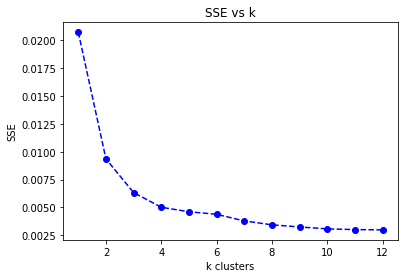

In [100]:
SSE = []
coords = list(cluster_df[['type_A_norm','longitude_norm','latitude_norm']].values)
for k in range(1,13):
    km = KMeans(n_clusters=k)
    km.fit(coords)
    labels = km.labels_
    centroids = km.cluster_centers_
    # Get the SSE
    SSE.append(sum(np.min(cdist(coords, centroids, 'euclidean'),axis=1))/len(coords))
    
plt.plot(range(1,13),SSE, 'bo--')
plt.xlabel('k clusters')
plt.ylabel('SSE')
plt.title('SSE vs k')

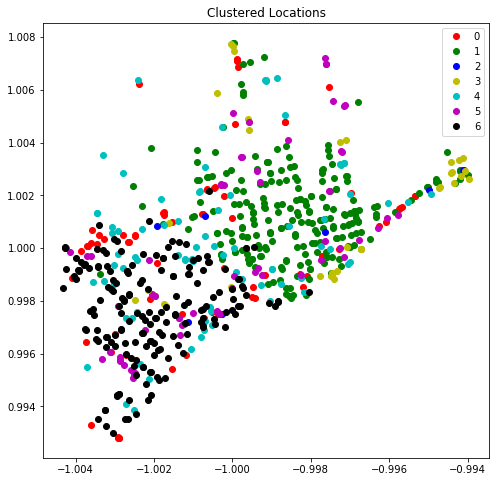

In [101]:
k = 7
km = KMeans(n_clusters=k)
km.fit(coords)
labels = km.labels_
centroids = km.cluster_centers_
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
plt.figure(figsize=(8,8))
plt.title('Clustered Locations')
for j in range(k):
    current_coords = np.asarray(coords)[np.where(labels==j)]
    j_longs = current_coords[:,1]
    j_lats =  current_coords[:,2]
    plt.plot(j_longs, j_lats, '%so' % colors[j], label=j)
plt.legend()

TypeError: 'type' object is not subscriptable

In [120]:
clf=svm.SVC()
clf.fit([[0,1],[3,3]],[0,1])
clf.support_vectors_

array([[ 0.,  1.],
       [ 3.,  3.]])

In [90]:
cluster_df['label'] = km.labels_

In [91]:
cluster_df.head()

,name,type_A,longitude,latitude,type_A_norm,longitude_norm,latitude_norm,label
"12731 Hwy 48 , Whitchurch-Stouffville, Ontario",Ultramar,115.6,-79.282378,43.976346,0.956242,-0.997435,1.005572,1
"1610 Keele St , Toronto - Central, Ontario",Shell,122.9,-79.471988,43.682320,1.016627,-0.999820,0.998849,2
"6897 Finch Ave W , Toronto - West, Ontario",Esso,121.9,-79.617364,43.734632,1.008355,-1.001649,1.000045,2
"1 Harwood Ave S , Ajax, Ontario",Pioneer,122.6,-79.025100,43.861027,1.014146,-0.994198,1.002935,6
"1 Thornhill Woods Dr , Vaughan, Ontario",Esso,122.9,-79.463886,43.826660,1.016627,-0.999718,1.002149,6


In [92]:
cluster_df.groupby('label')['type_A'].describe().sort_values('mean',ascending=False)['mean']

label
6    122.913080
2    122.781319
0    120.150000
3    118.354795
1    116.448276
5    113.851351
4    110.900000
Name: mean, dtype: float64

In [93]:
import gmplot
colors = ['#FF0000','#00FF00','0000FF','#FFFF00', '#00FFFF', '#FF00FF', '#000000']
gmap = gmplot.GoogleMapPlotter.from_geocode("Toronto")

for j in range(k):
    current_coords = np.asarray(cluster_df)[np.where(labels==j)]
    j_longs = current_coords[:,2]
    j_lats =  current_coords[:,3]
    gmap.scatter(j_lats, j_longs, '%s' %colors[j], size=200, marker=False)
gmap.draw('clustered.html')

ConnectionError: HTTPConnectionPool(host='maps.googleapis.com', port=80): Max retries exceeded with url: /maps/api/geocode/json?address=%22Toronto%22 (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x000001C33FCB10F0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))

In [94]:
cluster_df.head()

,name,type_A,longitude,latitude,type_A_norm,longitude_norm,latitude_norm,label
"12731 Hwy 48 , Whitchurch-Stouffville, Ontario",Ultramar,115.6,-79.282378,43.976346,0.956242,-0.997435,1.005572,1
"1610 Keele St , Toronto - Central, Ontario",Shell,122.9,-79.471988,43.682320,1.016627,-0.999820,0.998849,2
"6897 Finch Ave W , Toronto - West, Ontario",Esso,121.9,-79.617364,43.734632,1.008355,-1.001649,1.000045,2
"1 Harwood Ave S , Ajax, Ontario",Pioneer,122.6,-79.025100,43.861027,1.014146,-0.994198,1.002935,6
"1 Thornhill Woods Dr , Vaughan, Ontario",Esso,122.9,-79.463886,43.826660,1.016627,-0.999718,1.002149,6


In [97]:
cluster_df[cluster_df['label']==6]

,name,type_A,longitude,latitude,type_A_norm,longitude_norm,latitude_norm,label
"1 Harwood Ave S , Ajax, Ontario",Pioneer,122.6,-79.025100,43.861027,1.014146,-0.994198,1.002935,6
"1 Thornhill Woods Dr , Vaughan, Ontario",Esso,122.9,-79.463886,43.826660,1.016627,-0.999718,1.002149,6
"1000 Rowntree Dairy Rd , Vaughan, Ontario",Petro-Canada,122.9,-79.568114,43.784138,1.016627,-1.001030,1.001177,6
"10016 Bayview Ave , Richmond Hill, Ontario",Shell,122.9,-79.415928,43.876250,1.016627,-0.999115,1.003283,6
"1015 Sheppard Ave E , Toronto - North, Ontario",Canadian Tire,122.9,-79.372756,43.769550,1.016627,-0.998572,1.000843,6
"1030 Centre St , Vaughan, Ontario",Esso,122.9,-79.459104,43.809268,1.016627,-0.999658,1.001751,6
"1039 Danforth Rd , Toronto - East, Ontario",Esso,122.9,-79.247434,43.734560,1.016627,-0.996995,1.000043,6
"10579 Yonge St , Richmond Hill, Ontario",Esso,122.9,-79.440030,43.885360,1.016627,-0.999418,1.003491,6
"1077 Yonge St , Toronto - Central, Ontario",Shell,122.9,-79.390232,43.679376,1.016627,-0.998792,0.998781,6
"1081 Rutherford Rd , Vaughan, Ontario",Petro-Canada,122.9,-79.469569,43.844938,1.016627,-0.999790,1.002567,6


In [ ]:
# look only at the Toronto Cluster